In [1]:
!wget https://github.com/dicodingacademy/assets/releases/download/release/rockpaperscissors.zip
!unzip rockpaperscissors.zip

Streaming output truncated to the last 5000 lines.
  inflating: rockpaperscissors/scissors/KNNsNhduqSfuqEK5.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._KNNsNhduqSfuqEK5.png  
  inflating: rockpaperscissors/scissors/xAnfzBYnsnuru9Nf.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._xAnfzBYnsnuru9Nf.png  
  inflating: rockpaperscissors/scissors/caj9PiWZ2BenuxXF.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._caj9PiWZ2BenuxXF.png  
  inflating: rockpaperscissors/scissors/5CzwWCDnxKOJz5T0.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._5CzwWCDnxKOJz5T0.png  
  inflating: rockpaperscissors/scissors/7dBQ0fOpCs03OmnR.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._7dBQ0fOpCs03OmnR.png  
  inflating: rockpaperscissors/scissors/DXQaN15KphkE4i7z.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._DXQaN15KphkE4i7z.png  
  inflating: rockpaperscissors/scissors/0CSaM2vL2cWX6Cay.png  
  inflating: __MACOSX/rockpaperscissors/scissors/._0CSaM2vL2cWX6

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.layers import Conv2D, MaxPool2D, Flatten, Dense, InputLayer
from tensorflow.keras.models import Sequential


In [3]:
!rm -rf {'rockpaperscissors/rps-cv-images'}
!rm -rf {'rockpaperscissors/README_rpc-cv-images.txt'}

In [4]:
import os
import random
import shutil

# Tentukan direktori sumber (folder asal)
source_directory = 'rockpaperscissors'

# Tentukan direktori tujuan untuk data pelatihan
train_directory = 'train_data'

# Tentukan direktori tujuan untuk data validasi
validation_directory = 'validation_data'

# Buat direktori tujuan jika belum ada
os.makedirs(train_directory, exist_ok=True)
os.makedirs(validation_directory, exist_ok=True)

# Tentukan perbandingan data pelatihan (60%) dan validasi (40%)
train_split = 0.6

# Loop melalui setiap kelas (rock, paper, scissors)
for class_name in os.listdir(source_directory):
    class_directory = os.path.join(source_directory, class_name)
    train_class_directory = os.path.join(train_directory, class_name)
    validation_class_directory = os.path.join(validation_directory, class_name)

    # Buat direktori untuk kelas tertentu jika belum ada
    os.makedirs(train_class_directory, exist_ok=True)
    os.makedirs(validation_class_directory, exist_ok=True)

    # Ambil daftar file dalam kelas tertentu
    files = os.listdir(class_directory)

    # Hitung jumlah data yang akan dipindahkan ke pelatihan dan validasi
    num_train_samples = int(train_split * len(files))

    # Acak urutan file
    random.shuffle(files)

    # Pindahkan data ke direktori pelatihan
    train_files = files[:num_train_samples]
    for file in train_files:
        source_file = os.path.join(class_directory, file)
        destination_file = os.path.join(train_class_directory, file)
        shutil.move(source_file, destination_file)

    # Pindahkan data ke direktori validasi
    validation_files = files[num_train_samples:]
    for file in validation_files:
        source_file = os.path.join(class_directory, file)
        destination_file = os.path.join(validation_class_directory, file)
        shutil.move(source_file, destination_file)


In [5]:
train_datagen = ImageDataGenerator(
                    rescale = 1./255,
                    rotation_range = 30,
                    shear_range = 0.2,
                    width_shift_range=0.2,
                    height_shift_range=0.2,
                    zoom_range=0.2,
                    fill_mode = 'nearest',
                    horizontal_flip = True)

validation_datagen = ImageDataGenerator(
                        rescale = 1./255,
                        rotation_range = 30,
                        shear_range = 0.2,
                        width_shift_range=0.2,
                        height_shift_range=0.2,
                        zoom_range=0.2,
                        fill_mode = 'nearest',
                        horizontal_flip = True)

train_generator = train_datagen.flow_from_directory(
                    'train_data',
                    target_size = (200,300),
                    batch_size=32,
                    class_mode = 'categorical')

validation_generator = train_datagen.flow_from_directory(
                        'validation_data',
                        target_size = (200,300),
                        batch_size=32,
                        class_mode = 'categorical')

Found 1312 images belonging to 3 classes.
Found 876 images belonging to 3 classes.


In [6]:
model = Sequential()
model.add(InputLayer(input_shape=(200,300,3)))

model.add(Conv2D(25,(5,5), activation='relu', strides=(1,1), padding='same'))
model.add(MaxPool2D(pool_size=(2, 2), padding='same'))
model.add(Conv2D(50,(5,5), activation='relu', strides=(2,2), padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='same'))
model.add(Conv2D(75,(3,3), activation='relu', strides=(2,2), padding='same'))
model.add(MaxPool2D(pool_size=(2,2), padding='valid'))


model.add(Flatten())
model.add(Dense(units=512, activation='relu'))
model.add(Dense(units=3, activation='softmax'))


In [7]:
model.compile(loss='categorical_crossentropy',
              optimizer='Adam',
              metrics=['accuracy'])

In [10]:
from tensorflow.keras.callbacks import Callback

class AccuracyStopping(Callback):
    def __init__(self, target_accuracy=0.86):
        super(AccuracyStopping, self).__init__()
        self.target_accuracy = target_accuracy
        self.stopping_epoch = None

    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') >= self.target_accuracy:
            print(f"Reached target accuracy of {self.target_accuracy}, stopping training.")
            self.model.stop_training = True
            self.stopping_epoch = epoch

# Create the custom callback
accuracy_stopping_callback = AccuracyStopping(target_accuracy=0.86)

# Train the model with the custom callback
history = model.fit(
    train_generator,
    steps_per_epoch=16,
    epochs=18,
    validation_data=validation_generator,
    validation_steps=8,
    verbose=2,
    callbacks=[accuracy_stopping_callback]
)

stopping_epoch = accuracy_stopping_callback.stopping_epoch
print(f"Training stopped at epoch {stopping_epoch} due to reaching the target accuracy.")

Epoch 1/18
16/16 - 73s - loss: 0.3729 - accuracy: 0.8594 - val_loss: 0.3781 - val_accuracy: 0.8672 - 73s/epoch - 5s/step
Epoch 2/18
Reached target accuracy of 0.86, stopping training.
16/16 - 72s - loss: 0.3316 - accuracy: 0.8789 - val_loss: 0.3080 - val_accuracy: 0.8633 - 72s/epoch - 4s/step
Training stopped at epoch 1 due to reaching the target accuracy.


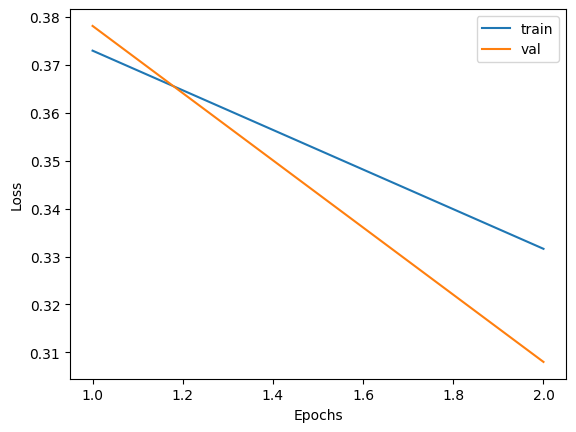

In [19]:
stopping_epoch
epochs = np.arange(1,stopping_epoch+2)
plt.plot(epochs, history.history['loss'],label='train')
plt.plot(epochs, history.history['val_loss'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.legend()

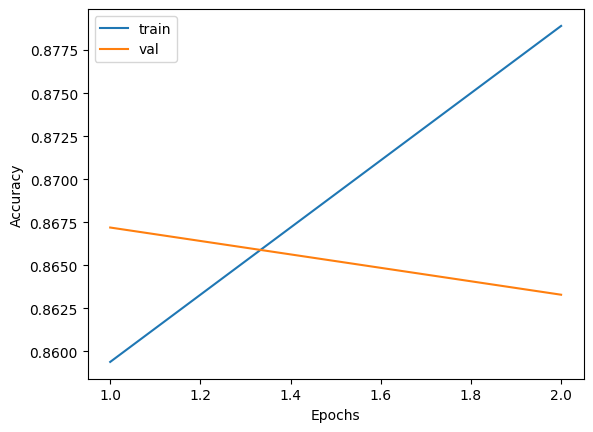

In [20]:
plt.plot(epochs, history.history['accuracy'],label='train')
plt.plot(epochs, history.history['val_accuracy'], label='val')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.legend()

Saving sWC2BZ7oeSzsCXva.png to sWC2BZ7oeSzsCXva.png
1/1 [==============================] - 0s 164ms/step
scissors


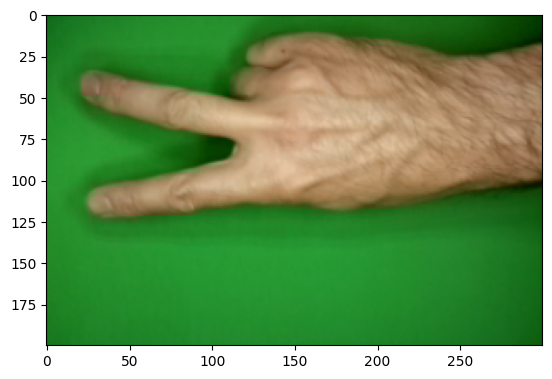

In [21]:
from google.colab import files
from keras.preprocessing import image
upload = files.upload()

for fn in upload.keys():

  path = fn
  img = image.load_img(path, target_size=(200,300))
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)

  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  thing = np.argmax(classes)

  if thing == 0:
    print('paper')
  elif thing == 1:
    print('rock')
  elif thing == 2:
    print('scissors')
  else:
    print('Unknown object')

Nama: William
Username: william_l2y7
